<a href="https://colab.research.google.com/github/primods/HepatitisSVM_Sampling/blob/main/HEPDS_DAUG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Import packages

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn import mixture
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report

import statsmodels.stats.api as sms

from mlxtend.plotting import plot_decision_regions

from imblearn.over_sampling import SMOTE

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
#Create the data frame
df = pd.read_csv("HepatitisCdata.csv").drop("Unnamed: 0", axis=1)
#Clean data
df = df[df["Category"] != "0s=suspect Blood Donor"]
df = df.dropna().reset_index().drop("index", axis=1)

In [3]:
#Split the training set
df_sample_train = df.sample(frac=.6,random_state=27)

#Select the test set
df_sample_test = df.iloc[list(set(df.index)-set(df_sample_train.index))]

In [4]:
#Check for sanity

len(df) == (len(df_sample_train)+len(df_sample_test))

True

In [5]:
#Count the classes

df_sample_train["Category"].value_counts()

0=Blood Donor    318
3=Cirrhosis       18
1=Hepatitis        8
2=Fibrosis         5
Name: Category, dtype: int64

In [6]:
#Make categorical to binary
df_sample_train.replace("0=Blood Donor",1, inplace=True)
df_sample_train.replace(["3=Cirrhosis","1=Hepatitis","2=Fibrosis"],-1, inplace=True)
df_sample_train["Category"].value_counts()

 1    318
-1     31
Name: Category, dtype: int64

In [7]:
#Random undersampling the healthy category and create a new dataframe
df_sample_train_healthy = df_sample_train[df_sample_train["Category"] == 1].sample(n=150, random_state=27)
df_sample_train_sick = df_sample_train[df_sample_train["Category"] == -1]
df_sample_train = pd.concat([df_sample_train_sick,df_sample_train_healthy]).reset_index(drop=True)
df_sample_train.columns

Index(['Category', 'Age', 'Sex', 'ALB', 'ALP', 'ALT', 'AST', 'BIL', 'CHE',
       'CHOL', 'CREA', 'GGT', 'PROT'],
      dtype='object')

In [8]:
#Select the most common values that anyone encounters in laboratory data and split

X_train = df_sample_train.drop("Category", axis=1)
X_train = X_train[["ALB","CHOL","AST","ALT"]]
y_train = df_sample_train["Category"]

In [9]:
#Create a Smote oversampler and fit
oversample = SMOTE()
X_train, y_train = oversample.fit_resample(X_train, y_train)
y_train.value_counts()

-1    150
 1    150
Name: Category, dtype: int64

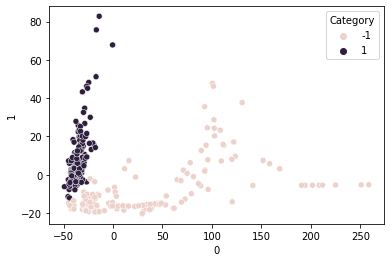

In [10]:
#PCA for dimensionality reduction and plot
pca = PCA(n_components=2)
X_train_pca = pd.DataFrame(pca.fit_transform(X_train))
sns.scatterplot(x=0, y=1, data=X_train_pca, hue=y_train)

In [11]:
#Gaussian mxtures for parameter estimation and data augmentation of both categories
clf = mixture.GaussianMixture(n_components=2, init_params="kmeans")
clf.fit(X_train_pca)

GaussianMixture(n_components=2)

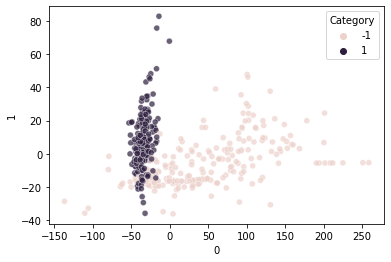

In [12]:
#First iteration of data augmentation
ndf_1 = pd.DataFrame(np.random.multivariate_normal(list(clf.means_[0]),
clf.covariances_[0], size=100))


ndf_1["Category"] = 1

ndf_2 = pd.DataFrame(np.random.multivariate_normal(list(clf.means_[1]),
clf.covariances_[1], size=100))


ndf_2["Category"] = -1

#COncatenating dataframes
aug_df = pd.concat([X_train_pca.join(y_train),pd.concat([ndf_2,ndf_1])]).reset_index(drop=True)
#Plot the new data
sns.scatterplot(x=0, y=1, data=aug_df, hue="Category", alpha=0.7)

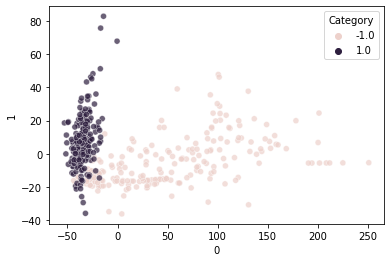

In [13]:
#Reconstruct the original data for boundary delimitation of the new generated data
train_original_data = X_train_pca.join(y_train)
min_train_val = train_original_data[train_original_data["Category"] == -1][0].describe()["min"]
max_train_val = train_original_data[train_original_data["Category"] == -1][0].describe()["max"]
#Separate the categories in the training set
train_aug_pos = aug_df[aug_df["Category"] == 1]
train_aug_neg = aug_df[aug_df["Category"] == -1]

#Function to filter the values
train_aug_neg_clean = []

for i in np.array(train_aug_neg):
  if i[0] > min_train_val and i[0]< max_train_val:
    train_aug_neg_clean.append(i)

train_aug_neg_clean = pd.DataFrame(train_aug_neg_clean)
train_aug_neg_clean.columns = train_aug_pos.columns

aug_train_data_clean = pd.concat([train_aug_neg_clean,train_aug_pos]).reset_index(drop=True)
aug_train_data_clean
#Plot the cleaned data
sns.scatterplot(x=0, y=1, data=aug_train_data_clean, hue="Category", alpha=0.7)

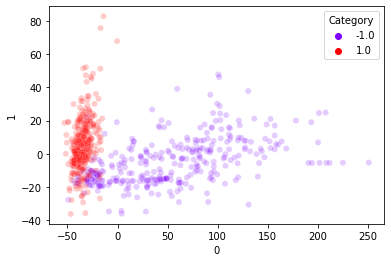

In [14]:
#Second iteration of data augmentation
clf = mixture.GaussianMixture(n_components=2, init_params="kmeans")
clf.fit(aug_train_data_clean.drop("Category", axis=1))

ndf_1_aug = pd.DataFrame(np.random.multivariate_normal(list(clf.means_[0]),
clf.covariances_[0], size=100))


ndf_1_aug["Category"] = 1

ndf_2_aug = pd.DataFrame(np.random.multivariate_normal(list(clf.means_[1]),
clf.covariances_[1], size=100))


ndf_2_aug["Category"] = -1

aug_df_f = pd.concat([aug_train_data_clean,pd.concat([ndf_2_aug,ndf_1_aug])]).reset_index(drop=True)

sns.scatterplot(x=0, y=1, data=aug_df_f, hue="Category", alpha=0.2, palette="rainbow")

In [15]:
#Split the train data
X_aug_train = aug_df_f.drop("Category",axis=1)
y_aug_train = aug_df_f["Category"]

In [16]:
#create SVM Class
svm = SVC()

#Grid search best parameters

parameters = {'kernel':('linear', 'rbf'), 'C':[1, 5, 10]}

clf = GridSearchCV(svm, parameters)
#Train the model
clf.fit(X_aug_train, y_aug_train)
#Best parameters
clf.best_params_

{'C': 10, 'kernel': 'rbf'}

In [21]:
#Create the model with the best parameters
svm_tunned = SVC(C=10, kernel="rbf")

In [22]:
#Confidence interval of coss validation scores k-20 fold
scores = cross_val_score(svm_tunned, X_aug_train, y_aug_train, cv=20)
sms.DescrStatsW(scores).tconfint_mean()

(0.9281288864917141, 0.9641400210713107)

In [23]:
#fit the new model to train data 
svm_tunned.fit(X_aug_train,y_aug_train)

SVC(C=10)

/usr/local/lib/python3.7/dist-packages/mlxtend/plotting/decision_regions.py:244: MatplotlibDeprecationWarning: Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.
  ax.axis(xmin=xx.min(), xmax=xx.max(), y_min=yy.min(), y_max=yy.max())


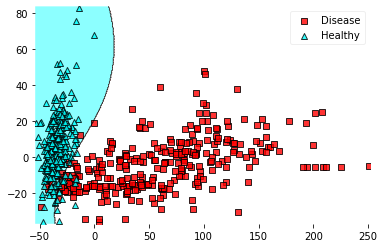

In [25]:
#Plot the decision boundaries
X_aug_train.shape
xdataplot = np.array(X_aug_train)
ydataplot = np.reshape(np.array(y_aug_train.astype("int64")), newshape=(688,),)
ax = plot_decision_regions(xdataplot, ydataplot, clf=svm_tunned, legend=1,colors="red,cyan")
handles, labels = ax.get_legend_handles_labels()

ax.legend(handles, 
          ['Disease', 'Healthy'], 
           framealpha=0.3, scatterpoints=1)
plt.show()

In [26]:
#Constructing the test set
X_test = df_sample_test[["ALB","CHOL","AST","ALT"]]
X_test = pca.transform(X_test)
y_test = df_sample_test["Category"]
y_test.replace("0=Blood Donor",1, inplace=True)
y_test.replace(["3=Cirrhosis","1=Hepatitis","2=Fibrosis"],-1, inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:6619: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


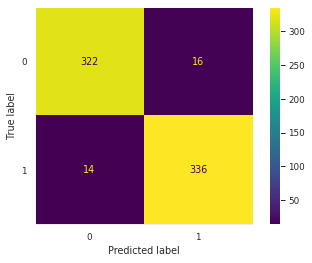

In [27]:
#Show metrics for the train data

y_train_pred = svm_tunned.predict(X_aug_train)

sns.set("paper")
cm_hep = confusion_matrix(y_aug_train, y_train_pred)
ConfusionMatrixDisplay(cm_hep).plot()
plt.grid(b=None)

In [28]:
#Summary of scores
print(classification_report(y_aug_train, y_train_pred, target_names=["Disease","Healthy"]))

              precision    recall  f1-score   support

     Disease       0.96      0.95      0.96       338
     Healthy       0.95      0.96      0.96       350

    accuracy                           0.96       688
   macro avg       0.96      0.96      0.96       688
weighted avg       0.96      0.96      0.96       688



In [29]:
#Create prediction data with the X test data
y_pred = svm_tunned.predict(X_test)

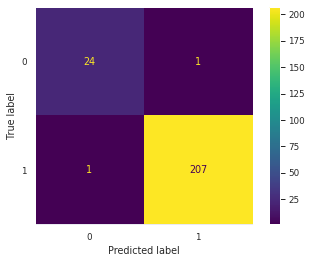

In [30]:
#Plot the Confusion Matrix

cm_hep = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm_hep).plot()
plt.grid(b=None)

In [31]:
#Summary of scores
print(classification_report(y_test, y_pred, target_names=["Disease","Healthy"]))

              precision    recall  f1-score   support

     Disease       0.96      0.96      0.96        25
     Healthy       1.00      1.00      1.00       208

    accuracy                           0.99       233
   macro avg       0.98      0.98      0.98       233
weighted avg       0.99      0.99      0.99       233



In [32]:
#Save the model and parameters
import pickle

parameters_plot = xdataplot, ydataplot

pickle.dump(svm_tunned, open("svmodel.sav", 'wb'))
pickle.dump(pca, open("pcamodel.sav", 'wb'))
pickle.dump(parameters_plot, open("paramsplot.sav", 'wb'))